# Credit Card Fraud Detection

In this project I will be building a credit card fraud detector. The data comes from https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [1]:
# import necesary packages
import pandas as pd
import numpy as np
import zipfile
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
!pip install xgboost
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_curve, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(42)
np.random.seed(42)

  Using cached xgboost-3.0.2-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached nvidia_nccl_cu12-2.27.5-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-3.0.2-py3-none-manylinux_2_28_x86_64.whl (253.9 MB)
Using cached nvidia_nccl_cu12-2.27.5-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (322.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]m1/2 [xgboost]


## Data Ingestion

In [2]:
# load dataset and display first 5 rows
creditcards = pd.read_csv("~/credit-card-fraud-detection-xgboost/data/creditcard.csv")
creditcards.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Feature Engineering

In [3]:
# create Hour of Day column and make it a dummy variable to take into account different fraud rates
# at different times of day
creditcards['Hour of Day'] = (creditcards['Time'] // 3600 % 24).astype(int)
creditcards = pd.get_dummies(creditcards, columns=['Hour of Day'], drop_first=True)

## Model Training

In [4]:
# use all of the features as XGB counters overfitting well 
X = creditcards.drop('Class', axis=1)
y = creditcards['Class']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [5]:
# Calculate scale_pos_weight (helps with class imbalance)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Set up XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,  
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=1
)

# Train model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=1, num_parallel_tree=None, ...)

## Model Evaluation

In [6]:
# Predictions
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

# Metrics
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUPRC Score:", average_precision_score(y_test, y_proba))

[[85281    14]
 [   31   117]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.89      0.79      0.84       148

    accuracy                           1.00     85443
   macro avg       0.95      0.90      0.92     85443
weighted avg       1.00      1.00      1.00     85443

AUPRC Score: 0.8434913741644866


Ideally I would want to base a predicition threshold based on the cost of false negatives vs false positives. Companies likely want to prioritize recall because missing fraud is expensive, but falsely flagging too many transactions as false positives also has costs associated with it due to frustrated customers Because we do not know the exact loss function of this credit card company, we cannot determine the exact best threshold for their problem. In our case, we will use the threshold that maximizes the F2 score, as this puts more weight on recall than precision (assuming that false negatives are more expensive than false positives).

In [7]:
from sklearn.metrics import fbeta_score
import numpy as np

thresholds = np.arange(0, 1.01, 0.01)
f2_scores = []

for thresh in thresholds:
    y_pred = (y_proba >= thresh).astype(int)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    f2_scores.append(f2)

# Find the threshold with the highest F2
best_thresh_idx = np.argmax(f2_scores)
best_thresh = thresholds[best_thresh_idx]
best_f2 = f2_scores[best_thresh_idx]

print(f"Best threshold for F2: {best_thresh:.2f}")
print(f"F2 Score at this threshold: {best_f2:.3f}")


Best threshold for F2: 0.05
F2 Score at this threshold: 0.832


In [8]:
# Make predictions based on best threshold
y_pred_best_f2 = (y_proba >= best_thresh).astype(int)

print("Confusion Matrix at Best F2 Threshold:")
print(confusion_matrix(y_test, y_pred_best_f2))
print("Classification Report at Best F2 Threshold:")
print(classification_report(y_test, y_pred_best_f2, target_names=['Legitimate', 'Fraud']))

Confusion Matrix at Best F2 Threshold:
[[85266    29]
 [   24   124]]
Classification Report at Best F2 Threshold:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     85295
       Fraud       0.81      0.84      0.82       148

    accuracy                           1.00     85443
   macro avg       0.91      0.92      0.91     85443
weighted avg       1.00      1.00      1.00     85443



/tmp/ipykernel_83/704722808.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


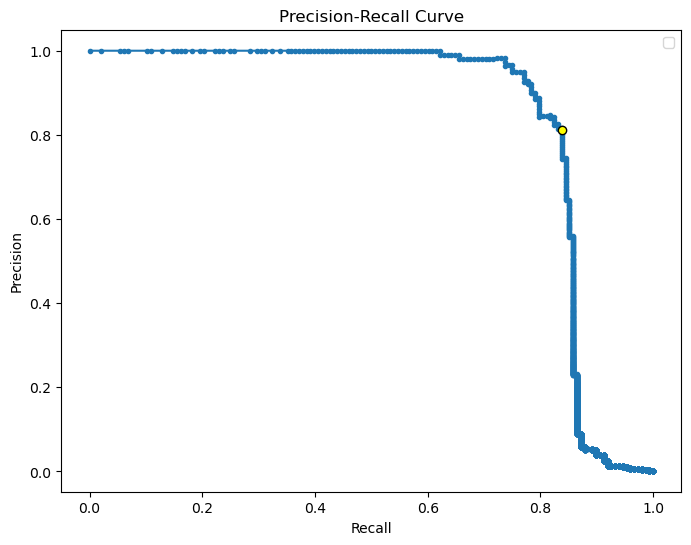

In [9]:
# Plot Precision-Recall Curve showing our chosen threshold that maxmizes F2
import matplotlib.pyplot as plt
import seaborn as sns
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.scatter([recall_score(y_test, y_pred_best_f2)], [precision_score(y_test, y_pred_best_f2)], c='yellow', edgecolors='black', zorder=2)
plt.plot(recall, precision, marker='.', zorder=1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

## Model Saving

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin

class ThresholdModel(BaseEstimator, ClassifierMixin):
    def __init__(self, model, threshold=0.5):
        self.model = model
        self.threshold = threshold

    def predict(self, X):
        probs = self.model.predict_proba(X)[:, 1]
        return (probs >= self.threshold).astype(int)

    def predict_proba(self, X):
        return self.model.predict_proba(X)


final_model = ThresholdModel(xgb_model, threshold=best_thresh)

with open('final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

## Conclusion

We built a credit card fraud detector using XGBoost that achieved an AUPRC of > 0.84, precision of 0.81, and recall of 0.84. This is strong performance given the extreme class imbalance in the dataset. While Random Forest achieved a higher maximum F2 score, we prioritized AUPRC since it reflects overall ranking quality and allows thresholds to be dynamically adjusted based on business priorities. By combining feature engineering, model selection, and hyperparameter tuning, we developed a model that balances high recall—critical in fraud detection—with strong precision.